# EDA & SHAP/LIME Explainability Analysis for AQI Prediction

## Overview
This notebook performs comprehensive Exploratory Data Analysis (EDA) and uses SHAP and LIME for model-agnostic feature importance explanations.

In [4]:
!pip install seaborn

In [5]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)

import sys
sys.path.insert(0, '../')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## Section 1: Load Data and Models

In [7]:
from src.mongodb_handler import MongoDBHandler
from src.feature_engineering import FeatureEngineer
import joblib
import json

# Load data from MongoDB
print("Loading data from MongoDB...")
db_handler = MongoDBHandler()
df = db_handler.get_training_data(days=60)
db_handler.close()

print(f"[OK] Loaded {len(df)} records")
print(f"\nData shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

Loading data from MongoDB...
Connected to MongoDB: aqi_user
Retrieved 1437 records
MongoDB connection closed
[OK] Loaded 1437 records

Data shape: (1437, 23)

First few rows:
            timestamp        date  hour  day  month  year  day_of_week  \
0 2025-11-25 16:00:00  2025-11-25    16   25     11  2025            1   
1 2025-11-25 17:00:00  2025-11-25    17   25     11  2025            1   
2 2025-11-25 18:00:00  2025-11-25    18   25     11  2025            1   
3 2025-11-25 19:00:00  2025-11-25    19   25     11  2025            1   
4 2025-11-25 20:00:00  2025-11-25    20   25     11  2025            1   

   is_weekend  time_of_day  aqi  ...   no2   so2    co  temperature  humidity  \
0           0            2  113  ...  49.7  20.7  1.08         23.0      34.0   
1           0            2  110  ...  37.1  20.3  0.91         22.1      36.0   
2           0            3  109  ...  26.1  19.8  0.74         21.5      37.0   
3           0            3  108  ...  19.9  19.4  0.62  

In [11]:
# Load trained models from MongoDB Cloud
print("Loading trained models from MongoDB Cloud...")
db_handler = MongoDBHandler()

models = {}
model_metadata = {}

# Get all models from MongoDB
all_models = db_handler.get_all_models_metadata()

if all_models:
    print(f"[OK] Found {len(all_models)} models in MongoDB Cloud")
    for model_info in all_models:
        model_name = model_info['model_name']
        # Load full model with binaries
        full_model = db_handler.get_model(model_name)
        if full_model:
            # Deserialize the model
            import pickle
            models[model_info['metrics']['model_display_name']] = pickle.loads(full_model['model_binary'])
            model_metadata[model_name] = model_info
            print(f"  ✅ Loaded: {model_info['metrics']['model_display_name']}")
else:
    print("[WARN] No models found in MongoDB Cloud. Some visualizations may be limited.")

db_handler.close()

print(f"\nLoaded Models: {list(models.keys())}")

Loading trained models from MongoDB Cloud...
Connected to MongoDB: aqi_user
[OK] Found 3 models in MongoDB Cloud
  ✅ Loaded: Random Forest
  ✅ Loaded: Gradient Boosting
  ✅ Loaded: Ridge Regression
MongoDB connection closed

Loaded Models: ['Random Forest', 'Gradient Boosting', 'Ridge Regression']


In [12]:
# Get feature names from MongoDB (from any model)
if model_metadata:
    # Get feature names from first model
    first_model_key = list(model_metadata.keys())[0]
    db_handler = MongoDBHandler()
    full_model = db_handler.get_model(first_model_key)
    feature_names = full_model['feature_names'] if full_model else []
    db_handler.close()
    print(f"[OK] Loaded {len(feature_names)} feature names from MongoDB Cloud")
else:
    # Fallback: extract from dataframe
    feature_names = [col for col in df.columns if col not in ['timestamp', 'date', 'aqi', '_id', 'inserted_at']]
    print(f"[WARN] Using {len(feature_names)} features from dataframe")

Connected to MongoDB: aqi_user
MongoDB connection closed
[OK] Loaded 22 feature names from MongoDB Cloud


## Section 2: Exploratory Data Analysis (EDA)

In [10]:
# Basic statistics
print("Data Statistics:")
print("="*60)
print(f"\nAQI - Target Variable:")
print(df['aqi'].describe())

print(f"\n\nPollutant Concentrations:")
pollutants = ['pm25', 'pm10', 'no2', 'so2', 'co', 'o3']
print(df[pollutants].describe())

Data Statistics:

AQI - Target Variable:
count    1437.000000
mean      108.419624
std        23.959459
min        67.000000
25%        89.000000
50%       106.000000
75%       126.000000
max       154.000000
Name: aqi, dtype: float64


Pollutant Concentrations:
              pm25         pm10          no2          so2           co  \
count  1437.000000  1437.000000  1437.000000  1437.000000  1437.000000   
mean     38.491301    47.647042    33.546834    22.978010     2.843817   
std      15.423044    24.211674    26.109698    10.644287    37.607679   
min       8.100000     8.100000     3.200000     6.600000     0.090000   
25%      27.300000    32.200000    12.300000    15.200000     0.560000   
50%      36.900000    42.500000    26.300000    20.200000     0.860000   
75%      47.300000    58.100000    47.400000    27.700000     1.260000   
max      95.900000   271.000000   138.500000    65.400000   970.000000   

                o3  
count  1437.000000  
mean     74.986082  
std    

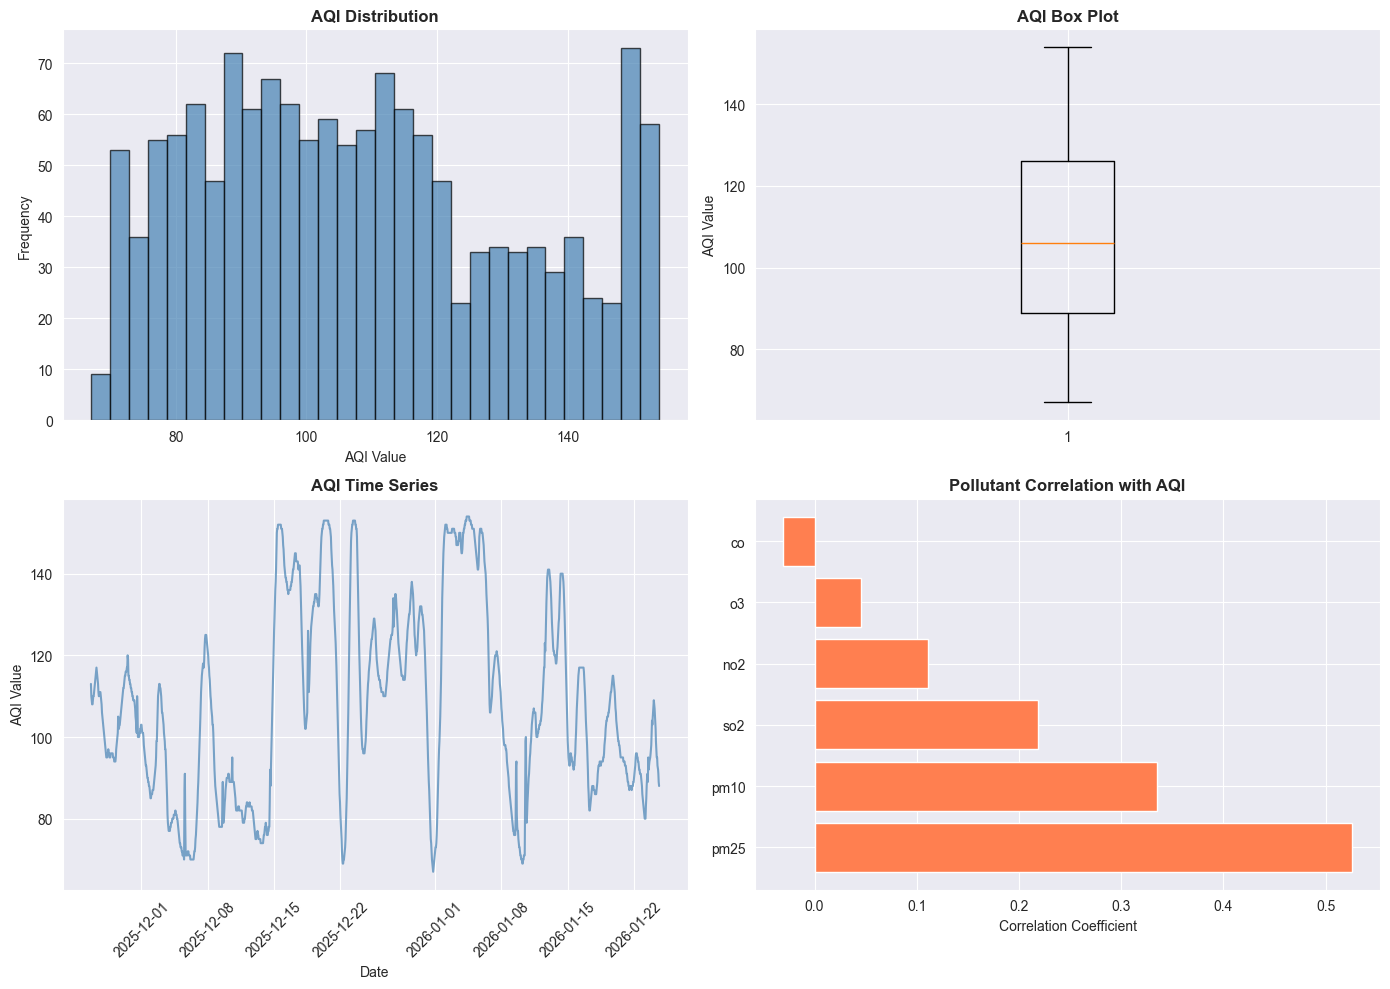


Pollutant Correlations with AQI:
pm25    0.525336
pm10    0.334782
so2     0.218188
no2     0.110497
o3      0.045289
co     -0.030441
Name: aqi, dtype: float64


In [13]:
# AQI Distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram
axes[0, 0].hist(df['aqi'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('AQI Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('AQI Value')
axes[0, 0].set_ylabel('Frequency')

# Box plot
axes[0, 1].boxplot(df['aqi'], vert=True)
axes[0, 1].set_title('AQI Box Plot', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('AQI Value')

# Time series
if 'timestamp' in df.columns:
    df_sorted = df.sort_values('timestamp')
    axes[1, 0].plot(df_sorted['timestamp'], df_sorted['aqi'], color='steelblue', alpha=0.7)
    axes[1, 0].set_title('AQI Time Series', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('AQI Value')
    axes[1, 0].tick_params(axis='x', rotation=45)

# Pollutants correlation with AQI
pollutants_with_aqi = pollutants + ['aqi']
corr_with_aqi = df[pollutants_with_aqi].corr()['aqi'].drop('aqi').sort_values(ascending=False)
axes[1, 1].barh(corr_with_aqi.index, corr_with_aqi.values, color='coral')
axes[1, 1].set_title('Pollutant Correlation with AQI', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Correlation Coefficient')

plt.tight_layout()
plt.savefig('../notebooks/plots/eda_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPollutant Correlations with AQI:")
print(corr_with_aqi)

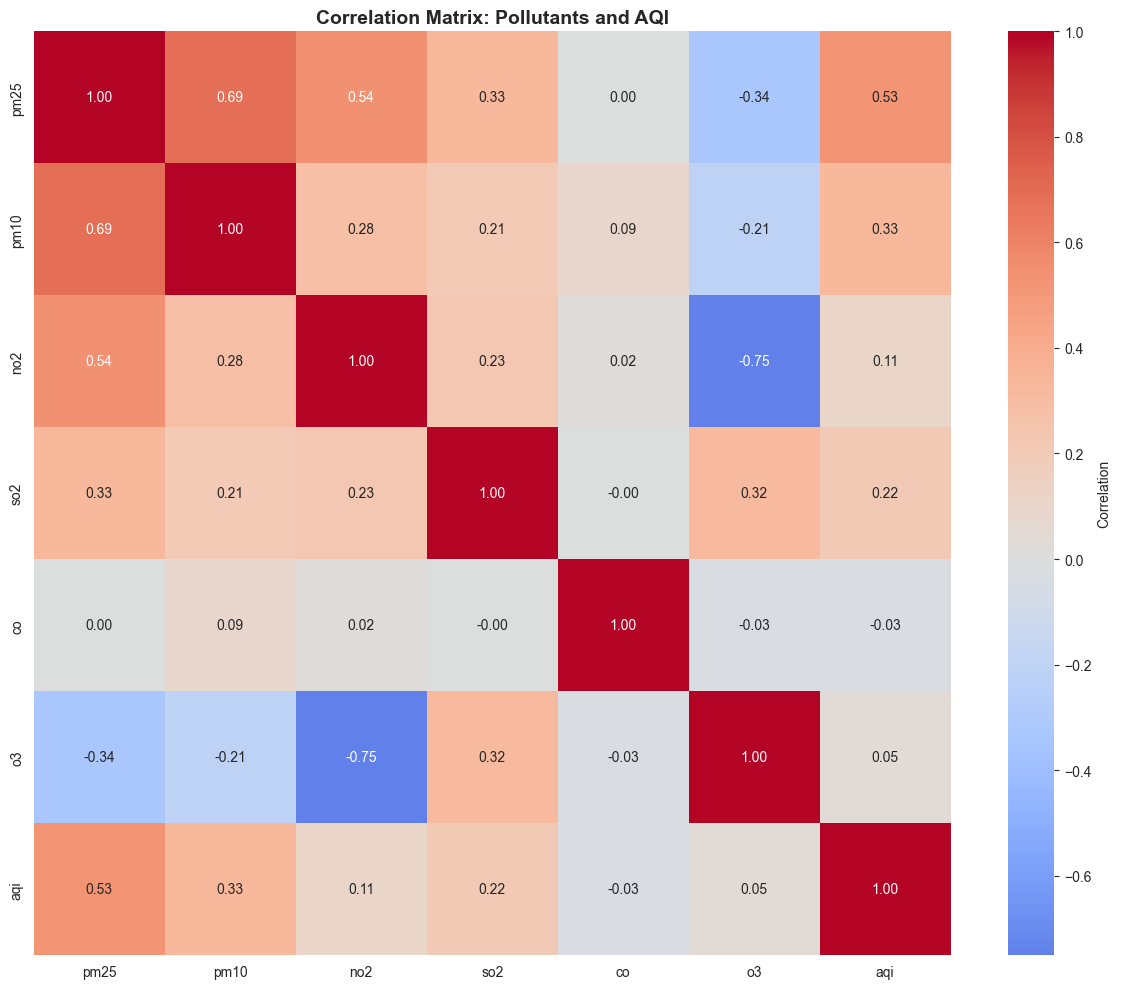

In [14]:
# Correlation matrix heatmap
fig, ax = plt.subplots(figsize=(12, 10))
corr_matrix = df[pollutants_with_aqi].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax, cbar_kws={'label': 'Correlation'})
ax.set_title('Correlation Matrix: Pollutants and AQI', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../notebooks/plots/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 3: Prepare Features and Generate Predictions

In [15]:
# Prepare features using the same approach as model training
print("Preparing features...")

# Use the same column exclusion as ModelTrainer
exclude_cols = ['aqi', 'timestamp', 'date', '_id', 'inserted_at', 
                'station_name', 'latitude', 'longitude']

# Use features that the model was trained on (from feature_names.json)
# Only use columns that exist in both feature_names and df
available_features = [f for f in feature_names if f in df.columns]

if not available_features:
    print(f"[WARN] No matching features. Falling back to numeric columns...")
    available_features = [col for col in df.columns 
                         if col not in exclude_cols 
                         and df[col].dtype in ['int64', 'float64']]

print(f"Using {len(available_features)} features: {available_features[:5]}...")

# Create feature matrix directly from DataFrame columns
X = df[available_features].copy()
X = X.fillna(X.median(numeric_only=True))
y = df['aqi'].values

print(f"[OK] Feature matrix shape: {X.shape}")
print(f"[OK] Target shape: {y.shape}")

# Update feature_names to match what we're using
feature_names = available_features

Preparing features...
Using 11 features: ['hour', 'day', 'month', 'year', 'day_of_week']...
[OK] Feature matrix shape: (1437, 11)
[OK] Target shape: (1437,)


## Section 4: SHAP Feature Importance Analysis

In [16]:
import shap

print("Generating SHAP Explanations...\n")

# For each model
shap_results = {}

for model_name, model in models.items():
    print(f"Processing {model_name}...")
    
    try:
        # Sample data for SHAP
        background_data = X.iloc[:min(100, len(X))]
        
        # Create SHAP explainer
        if 'RandomForest' in str(type(model).__name__) or 'GradientBoosting' in str(type(model).__name__):
            explainer = shap.TreeExplainer(model)
        else:
            explainer = shap.KernelExplainer(model.predict, background_data)
        
        # Calculate SHAP values
        shap_values = explainer.shap_values(X.iloc[:min(100, len(X))])
        
        # Handle different formats
        if isinstance(shap_values, list):
            shap_values = shap_values[0]
        
        # Calculate feature importance
        feature_importance = np.abs(shap_values).mean(axis=0)
        importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': feature_importance
        }).sort_values('Importance', ascending=False)
        
        shap_results[model_name] = importance_df
        
        print(f"[OK] {model_name} - Top 10 Features:")
        for idx, row in importance_df.head(10).iterrows():
            print(f"    {row['Feature']:.<40} {row['Importance']:.4f}")
        print()
        
    except Exception as e:
        print(f"[FAIL] Error with {model_name}: {e}\n")

: 

In [ ]:
# Visualize SHAP importance for all models
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

for idx, (model_name, importance_df) in enumerate(shap_results.items()):
    top_features = importance_df.head(15)
    axes[idx].barh(top_features['Feature'], top_features['Importance'], color=f'C{idx}')
    axes[idx].set_xlabel('Mean |SHAP value|')
    axes[idx].set_title(f'SHAP Feature Importance - {model_name}', fontweight='bold')
    axes[idx].invert_yaxis()

plt.suptitle('SHAP Feature Importance Across All Models', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../notebooks/plots/shap_importance_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

print("SHAP importance plots saved!")

## Section 5: LIME Feature Importance Analysis

In [ ]:
import lime
import lime.lime_tabular

print("Generating LIME Explanations...\n")

lime_results = {}

for model_name, model in models.items():
    print(f"Processing {model_name}...")
    
    try:
        # Create LIME explainer
        explainer = lime.lime_tabular.LimeTabularExplainer(
            X.values,
            feature_names=X.columns.tolist(),
            mode='regression',
            verbose=False
        )
        
        # Explain multiple instances
        lime_importances = pd.DataFrame(columns=['Feature', 'Weight'])
        
        for i in range(min(5, len(X))):
            exp = explainer.explain_instance(X.iloc[i], model.predict, num_features=20)
            exp_list = exp.as_list()
            
            for feature, weight in exp_list:
                feature_name = feature.split()[0] if feature else 'unknown'
                if feature_name in X.columns:
                    lime_importances = pd.concat([
                        lime_importances,
                        pd.DataFrame({'Feature': [feature_name], 'Weight': [abs(weight)]})
                    ], ignore_index=True)
        
        # Aggregate
        if len(lime_importances) > 0:
            lime_agg = lime_importances.groupby('Feature')['Weight'].mean().sort_values(ascending=False)
            lime_results[model_name] = lime_agg
            
            print(f"[OK] {model_name} - Top 10 Features:")
            for idx, (feature, weight) in enumerate(lime_agg.head(10).items()):
                print(f"    {feature:.<40} {weight:.4f}")
            print()
        else:
            print(f"[FAIL] No LIME importances for {model_name}\n")
            
    except Exception as e:
        print(f"[FAIL] Error with {model_name}: {e}\n")

In [ ]:
# Visualize LIME importance
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

for idx, (model_name, importance_series) in enumerate(lime_results.items()):
    top_features = importance_series.head(15)
    axes[idx].barh(top_features.index, top_features.values, color=f'C{idx+3}')
    axes[idx].set_xlabel('Mean Weight')
    axes[idx].set_title(f'LIME Feature Importance - {model_name}', fontweight='bold')
    axes[idx].invert_yaxis()

plt.suptitle('LIME Feature Importance Across All Models', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../notebooks/plots/lime_importance_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

print("LIME importance plots saved!")

## Section 6: Key Findings Summary

In [ ]:
print("\n" + "="*80)
print("KEY FINDINGS - FEATURE IMPORTANCE SUMMARY")
print("="*80)

print("\n1. SHAP ANALYSIS (SHAPLEY VALUES):")
print("-" * 80)
for model_name, importance_df in shap_results.items():
    print(f"\n{model_name}:")
    print(f"  Top 5 Features:")
    for idx, row in importance_df.head(5).iterrows():
        print(f"    â€¢ {row['Feature']:.<40} {row['Importance']:.4f}")

print("\n\n2. LIME ANALYSIS (LOCAL INTERPRETABLE MODEL-AGNOSTIC):")
print("-" * 80)
for model_name, importance_series in lime_results.items():
    print(f"\n{model_name}:")
    print(f"  Top 5 Features:")
    for idx, (feature, weight) in enumerate(importance_series.head(5).items()):
        print(f"    â€¢ {feature:.<40} {weight:.4f}")

print("\n\n3. TREND ANALYSIS:")
print("-" * 80)
print(f"  Data Points: {len(df)}")
print(f"  AQI Range: {df['aqi'].min():.1f} - {df['aqi'].max():.1f}")
print(f"  AQI Mean: {df['aqi'].mean():.1f}")
print(f"  AQI Std Dev: {df['aqi'].std():.1f}")

print("\n  Top Pollutant Correlations with AQI:")
corr_with_aqi_sorted = df[pollutants_with_aqi].corr()['aqi'].drop('aqi').sort_values(ascending=False)
for feature, corr in corr_with_aqi_sorted.head(5).items():
    print(f"    â€¢ {feature:.<40} {corr:.4f}")

print("\n" + "="*80)
print("Analysis Complete!")
print("="*80)